### Reproduzindo os grágicos do artigo:

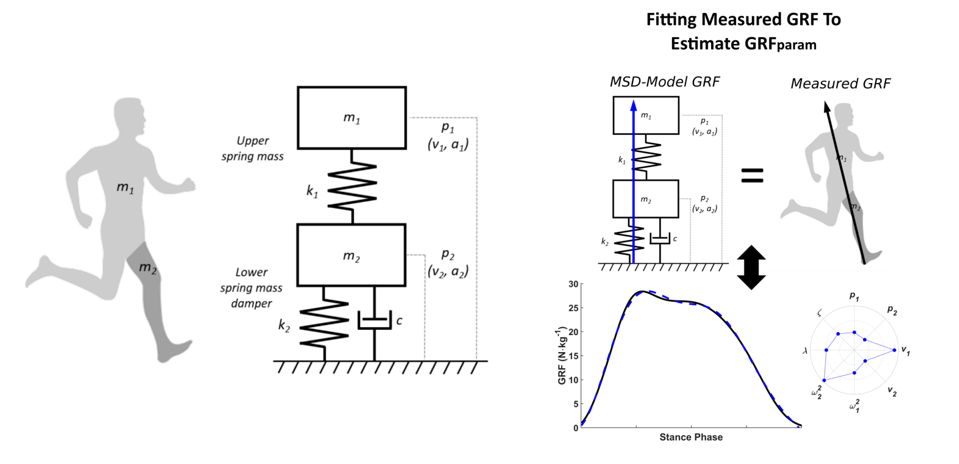

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [8]:
#-----Dados------
file_path = r"Raw Data_GRF.xlsx"
sheet_name_measured = "Measured GRF"
df_measured = pd.read_excel(file_path, sheet_name=sheet_name_measured, header=2)

t_measured = df_measured.iloc[:, 0].values  
grf_measured = df_measured.iloc[:, 1].values 

sheet_name_measured = "Measured TrunkAcc"
df_measured = pd.read_excel(file_path, sheet_name=sheet_name_measured, header=2)

g_1 = df_measured.iloc[:, 1].values
t_g_1 = df_measured.iloc[:, 0].values


m1 = 149.11                     #15,2kg e 149,11N                  
m2 = 596.44                     #60,8kg e 596,44N                 
g = -9.81                       #m/s²
c = 0.35                        #adotado
p1 = 0.1                        #adotado
k1_inicial = 15000              #adotado
k2_inicial = 54500              #adotado
v2_inicial = -0.2               #adotado
c = 0.35                        #adotado

#-----Calculo de a1-----
a1_calc = g_1*g

#-----Interpolação de a1 para igualar o tamanho de a1_calc com p2_calc, por NUMPY-----

# Número de pontos desejados
novo_tamanho = len(t_measured)
indices_originais = np.linspace(0, 1, len(a1_calc))
novos_indices = np.linspace(0, 1, novo_tamanho)

# Interpolação
a1_interpolado = np.interp(novos_indices, indices_originais, a1_calc)

#-----Cálculo de omega com as condições iniciais-----
omega_1_inicial = k1_inicial/m1
omega_2_inicial = k2_inicial/m2

#-----Otimização de k1 e k2------

#Função objetivo:
k1 = omega_1_inicial*m1
k2 = omega_2_inicial*m2

def objetivo(x):
    k1, k2 = x
    omega_1 = k1/m1
    omega_2 = k2/m2
    erro_omega_1 = (omega_1 - omega_1_inicial)**2
    erro_omega_2 = (omega_2 - omega_2_inicial)**2
    return erro_omega_1 + erro_omega_2  

# Restrição: k1 deve ser menor que k2
def restricao_k1_menor_k2(x):
    k1, k2 = x
    return k2 - k1  # Garantindo que k2 > k1

# Limites para k1 e k2
bounds = [(1000, 545000), (5000, 166700)]  

# Configuração das restrições
restricao = {'type': 'ineq', 'fun': restricao_k1_menor_k2}

# Aplicando a otimização
resultado = minimize(objetivo, x0=[k1_inicial, k2_inicial], bounds=bounds, constraints=[restricao])

# Verificando se a otimização foi bem-sucedida
if resultado.success:
    k1_otimizado, k2_otimizado = resultado.x
    resultado_otimizado = {
        "k1_otimizado (N/m)": k1_otimizado,
        "k2_otimizado (N/m)": k2_otimizado,
        "Sucesso": resultado.success,
        "Mensagem": resultado.message
    }
    print("Otimização bem-sucedida!")
    print(f"k1_otimizado = {k1_otimizado:.2f} N/m")
    print(f"k2_otimizado = {k2_otimizado:.2f} N/m")
else:
    resultado_otimizado = {
        "Sucesso": resultado.success,
        "Mensagem": resultado.message
    }
    print("Otimização falhou.")
    print("Motivo:", resultado.message)
resultado_otimizado

#-----Cálculo de omega com k1 e k2 otimizado-----
omega_1_calc = k1_otimizado/m1
omega_2_calc = k2_otimizado/m2

#-----Cálculo de p2 com as consdições inidicias e grf_medido-----
p2_calc = (((grf_measured/k2_otimizado)-(c*v2_inicial/(np.sqrt(k2_otimizado*m2))))*m2)/k2_otimizado

Otimização bem-sucedida!
k1_otimizado = 15000.00 N/m
k2_otimizado = 54500.00 N/m


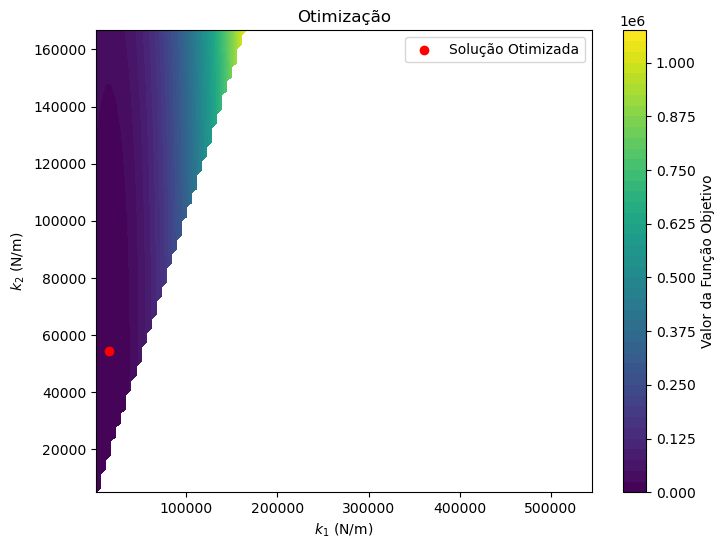

In [9]:
#-----Plotar gráfico de otimização------

k1_vals = np.linspace(1000, 545000, 100)
k2_vals = np.linspace(5000, 166700, 100)
K1, K2 = np.meshgrid(k1_vals, k2_vals)
Z = np.array([[objetivo([k1, k2]) if k2 > k1 else np.nan for k1 in k1_vals] for k2 in k2_vals])

plt.figure(figsize=(8, 6))
contour = plt.contourf(K1, K2, Z, levels=50, cmap='viridis')
plt.colorbar(label="Valor da Função Objetivo")
plt.xlabel("$k_1$ (N/m)")
plt.ylabel("$k_2$ (N/m)")
plt.title("Otimização")

if resultado.success:
    k1_otimizado, k2_otimizado = resultado.x
    plt.scatter(k1_otimizado, k2_otimizado, color='red', marker='o', label="Solução Otimizada")

plt.legend()
plt.show()

In [10]:
#-----Obtendo v1, v2, a1 e a2------

p1 = ((-a1_interpolado + g) / omega_1_calc) + p2_calc
v1 = np.gradient(p1, t_measured)
a1 = np.gradient(v1, t_measured)

p2 = p1 + ((a1 - g) / omega_1_calc) 
v2 = np.gradient(p2, t_measured)
a2 = np.gradient(v2, t_measured)

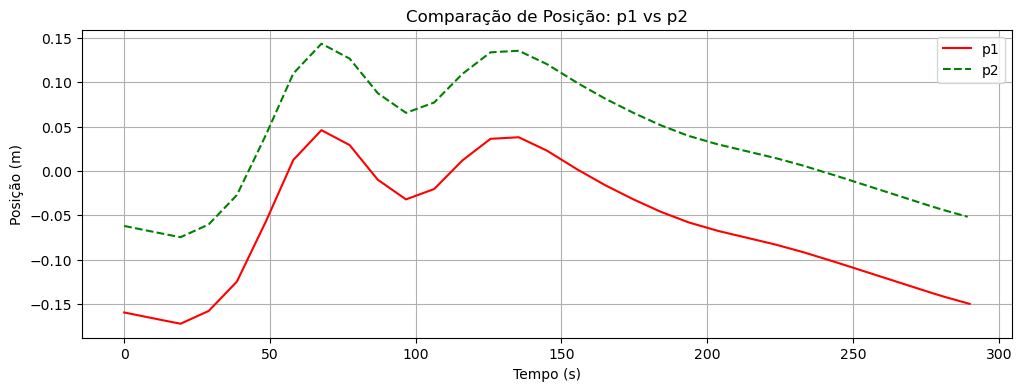

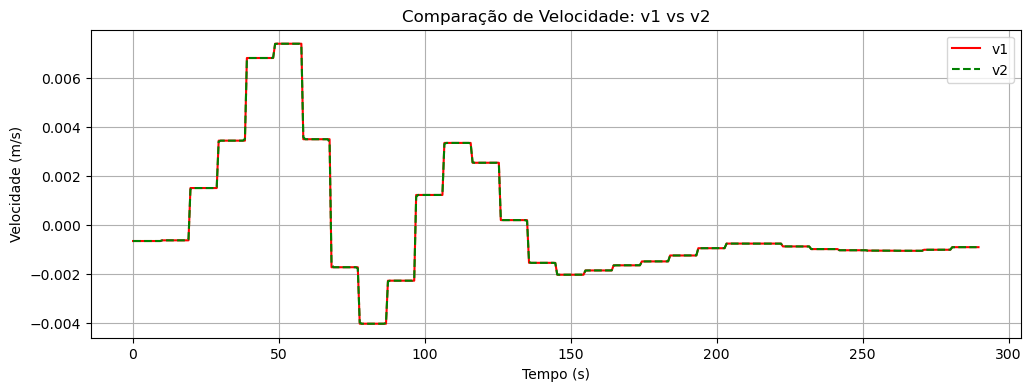

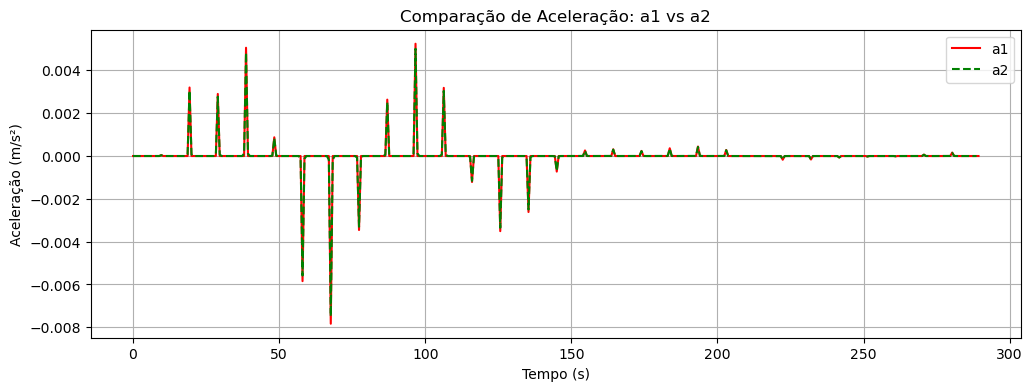

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(t_measured, p1, label='p1', color='red')
plt.plot(t_measured, p2, label='p2', linestyle='--', color='green')
plt.title('Comparação de Posição: p1 vs p2')
plt.xlabel('Tempo (s)')
plt.ylabel('Posição (m)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(t_measured, v1, label='v1', color='red')
plt.plot(t_measured, v2, label='v2', linestyle='--', color='green')
plt.title('Comparação de Velocidade: v1 vs v2')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (m/s)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(t_measured, a1, label='a1', color='red')
plt.plot(t_measured, a2, label='a2', linestyle='--', color='green')
plt.title('Comparação de Aceleração: a1 vs a2')
plt.xlabel('Tempo (s)')
plt.ylabel('Aceleração (m/s²)')
plt.legend()
plt.grid(True)
plt.show()


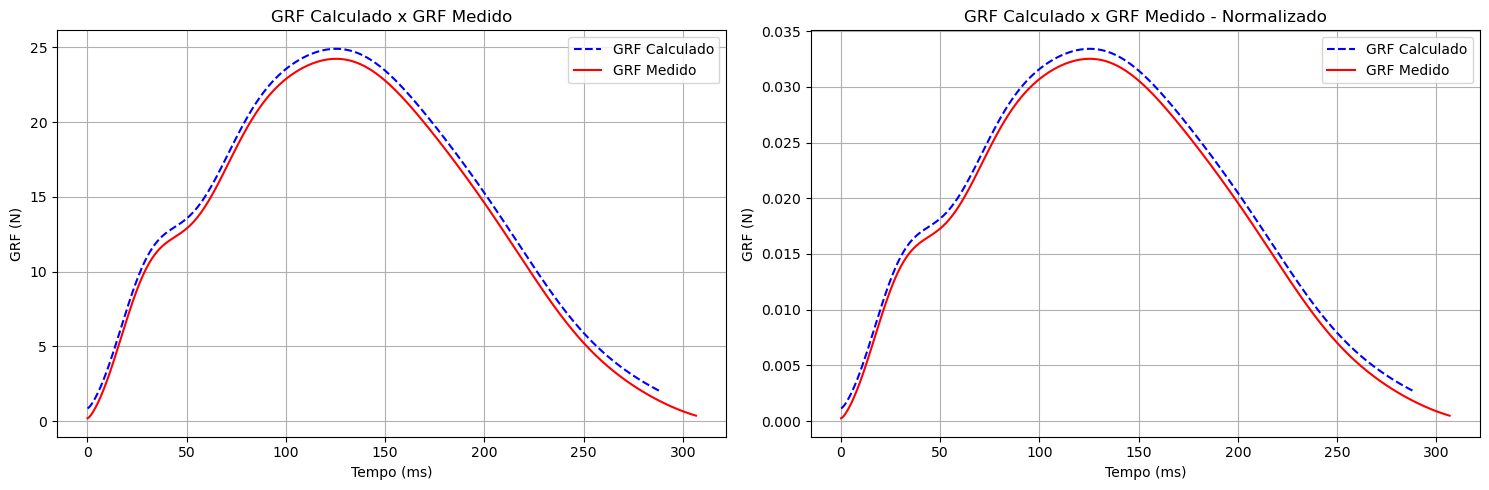

In [12]:
#-----VGRF------
grf_calc = k2_otimizado*((k2_otimizado*p2_calc)/m2) + ((c*v2)/np.sqrt(k2_otimizado*m2))
grf_normalizada = grf_calc/(m1+m2)
grf_measured_normalizada = grf_measured/(m1+m2)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))  
axes[0].plot(t_measured, grf_calc, label="GRF Calculado", color="blue", linestyle="--")
axes[0].plot(t_measured, grf_measured, label="GRF Medido", color="red")
axes[0].set_xlabel("Tempo (ms)")
axes[0].set_ylabel("GRF (N)")
axes[0].legend()
axes[0].set_title("GRF Calculado x GRF Medido")
axes[0].grid()

axes[1].plot(t_measured, grf_normalizada, label="GRF Calculado", color="blue", linestyle="--")
axes[1].plot(t_measured, grf_measured_normalizada, label="GRF Medido", color="red")
axes[1].set_xlabel("Tempo (ms)")
axes[1].set_ylabel("GRF (N)")
axes[1].legend()
axes[1].set_title("GRF Calculado x GRF Medido - Normalizado")
axes[1].grid()

plt.tight_layout()
plt.show()

##resample

